# DLNLP - Data Preprocessing

#### 0. Setup

In [103]:
# Import libraries
from tqdm import tqdm
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image

#### 1. Download Data using HuggingFace API

In [ ]:
# Get Data from HuggingFace
import requests

def query():
    response = requests.get(API_URL)
    return response.json()

# Limitation tackled: Maximum query length is 100, but dataset has 24,783 rows
results = []
for i in tqdm(range (0,24701,100)):
    API_URL = "https://datasets-server.huggingface.co/rows?dataset=hate_offensive&config=default&split=train&offset={}".format(str(i))
    result = query()
    results.extend(result['rows'])

# print(len(results))

In [ ]:
num = len(results)
rows = []
for i in range(num):
    rows.append(results[i]['row'])
    

In [90]:
# List to Pandas
data_pd = pd.DataFrame(rows)
data_pd.head(5)

,total_annotation_count,hate_speech_annotations,offensive_language_annotations,neither_annotations,label,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [91]:
# Save as '.csv' file
data_path = '../Datasets/HateSpeech.csv'
data_pd.to_csv(data_path)

#### 2. Data Preprocessing

##### 2.1 Data Analysis

In [287]:
# Read data from presaved dataset
data = pd.read_csv('../Datasets/TweetHate.csv',index_col=False)
data.head(3)

,Unnamed: 0,total_annotation_count,hate_speech_annotations,offensive_language_annotations,neither_annotations,label,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...


In [111]:
# Remove irrelevant columns
data = data.drop(columns=['Unnamed: 0','total_annotation_count','hate_speech_annotations','offensive_language_annotations','neither_annotations'])
data.head(3)

,label,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...


In [112]:
data.describe()

,label
count,24783.000000
mean,1.110277
std,0.462089
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,2.000000


In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


In [114]:
data.tweet

0        !!! RT @mayasolovely: As a woman you shouldn't...
1        !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2        !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3        !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4        !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
                               ...                        
24778    you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779    you've gone and broke the wrong heart baby, an...
24780    young buck wanna eat!!.. dat nigguh like I ain...
24781                youu got wild bitches tellin you lies
24782    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

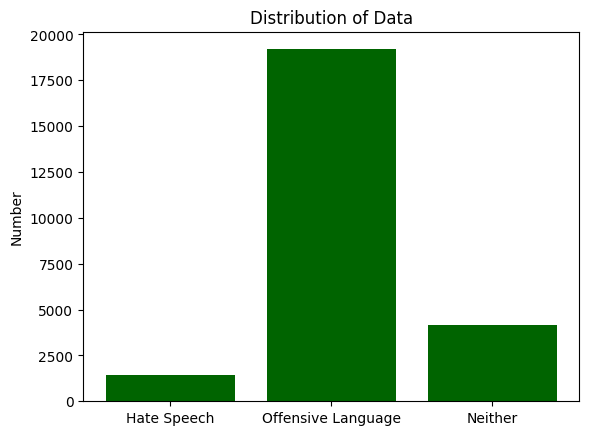

In [108]:
# Distribution of Dataset
label2txt = {0:'Hate Speech',1:'Offensive Language',2:'Neither'}
txt = ['Hate Speech','Offensive Language','Neither']
labels = [data['label'].value_counts()[i] for i in range(3)]

# Plot
plt.figure()
plt.bar(txt,labels,color='darkgreen')
plt.title('Distribution of Data')
plt.ylabel('Number')
plt.show()

##### 2.2 Data Cleaning and Normalization

In [252]:
import re
import nltk
from nltk.stem.porter import *
import contractions
from unidecode import unidecode
import pkg_resources
from symspellpy import SymSpell, Verbosity

# Abbreviation in Social Network
def remove_abbreviations(tweet):
    tweet = tweet.str.replace(r" plz", " please", regex=True)
    tweet = tweet.str.replace(r"rt",' ',regex=True)
    tweet = tweet.str.replace(r"lmao", "laughing my ass off",regex=True)
    tweet = tweet.str.replace(r" lol",' laugh out loud',regex=True)

    return tweet

def clean(tweet):
    #Lower Case
    tweet = tweet.str.lower()

    #URLs: deal with links like [http://abcd.com] or [xxx.com]
    url_regex = re.compile("(\w+\.com ?/ ?.+)|(http\S+)")
    #tweet = re.sub(url_regex, 'HTTPURL',tweet)
    tweet = tweet.str.replace(url_regex,'HTTPURL',regex=True)
    
    #User Mention
    user_regex = re.compile(r'@[\w\-]+')
    #tweet = re.sub(user_regex,'@USER',tweet)
    tweet = tweet.str.replace(user_regex,'@USER',regex=True)

    #Remove Unicode(start with &)
    uni_regex = re.compile(r'&[0-9a-zA-Z,#]+')
    #tweet = re.sub(uni_regex,'',tweet)
    tweet = tweet.str.replace(uni_regex,'',regex=True)

    #Hashtag
    tag_regex = re.compile(r'#+')
    #tweet = re.sub(tag_regex,'',tweet)
    tweet = tweet.str.replace(tag_regex,'',regex=True)
    #tweet = re.sub(r"_", " ", tweet)
    tweet = tweet.str.replace(r"_", " ",regex=True)

    #Punctuations & Numbers
    punc_regex = re.compile(r"[^a-zA-Z@\s]*")
    #tweet = re.sub(punc_regex, "",tweet)
    tweet = tweet.str.replace(punc_regex, "",regex=True)

    #Abbreviation/Acronym Disambiguation
    tweet = remove_abbreviations(tweet)

    # Repeat Character
    tweet = tweet.str.replace(r'([A-Za-z])\1{2,}', r'\1',regex=True)

    #Duplicate Space
    white_regex = re.compile(r'\s+')
    #tweet = re.sub(white_regex, ' ',tweet)
    tweet = tweet.str.replace(white_regex, ' ',regex=True)

    return tweet

# Stemming
stemmer = PorterStemmer()
def stemming(cleaned_tweet):
    result = ' '.join(stemmer.stem(i)if i not in ['HTTPURL','@USER'] else i for i in cleaned_tweet.split())
    return result

# Correct Spelling
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
def correct_spelling_symspell(text):
    words = [
        sym_spell.lookup(
            word, 
            Verbosity.CLOSEST, 
            max_edit_distance=2,
            include_unknown=True
            )[0].term 
        for word in text.split()] 
    text = " ".join(words)
    return text

# Correcting Componded Words
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
def correct_spelling_symspell_compound(text):
    words = [
        sym_spell.lookup_compound(
            word, 
            max_edit_distance=2
            )[0].term 
        for word in text.split()] 
    text = " ".join(words)
    return text

# Preprocessing
def preprocess(tweet):
    out = clean(tweet)
    # Contraction is considered: e.g. 'u'->'you'
    out = out.apply(contractions.fix)
    # Deal with borrowed words like résumé
    out = out.apply(unidecode)
    '''
    out = out.apply(correct_spelling_symspell)
    out = out.apply(correct_spelling_symspell_compound)
    '''
    return out

In [253]:
# Perform data cleaning via function defined above
tweets = data['tweet']
data['cleaned'] = preprocess(tweets)

In [254]:
data.cleaned

0         @USER as a woman you should not complain abou...
1         @USER boy dats coldtyga dwn bad for cuffin da...
2         @USER dawg @USER you ever fuck a bitch and sh...
3                       @USER @USER she look like a tranny
4         @USER the shit you hear about me might be tru...
                               ...                        
24778    yous a muthafin lie @USER @USER @USER right hi...
24779    you have gone and broke the wrong hea baby and...
24780    young buck want to eat dat nigguh like i are n...
24781                youu got wild bitches tellin you lies
24782    ruffled ntac eileen dahlia beautiful color com...
Name: cleaned, Length: 24783, dtype: object

In [255]:
data.head(5)

,label,tweet,cleaned
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,@USER as a woman you should not complain abou...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,@USER boy dats coldtyga dwn bad for cuffin da...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,@USER dawg @USER you ever fuck a bitch and sh...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,@USER @USER she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,@USER the shit you hear about me might be tru...


In [275]:
def tohateful(label):
    return 0 if label<2 else 1

In [276]:
l = data.label
data['class'] = l.apply(tohateful)
data = data.drop(columns=['tweet','label'])

In [280]:
data.head(5)

,cleaned,class
0,@USER as a woman you should not complain abou...,1
1,@USER boy dats coldtyga dwn bad for cuffin da...,0
2,@USER dawg @USER you ever fuck a bitch and sh...,0
3,@USER @USER she look like a tranny,0
4,@USER the shit you hear about me might be tru...,0


In [278]:
data['class'].value_counts()

class
0    20620
1     4163
Name: count, dtype: int64

In [283]:
# Save as '.csv' file
cleandata_path = '../Datasets/clean.csv'
data.to_csv(cleandata_path)

##### 2.3 Visualisation

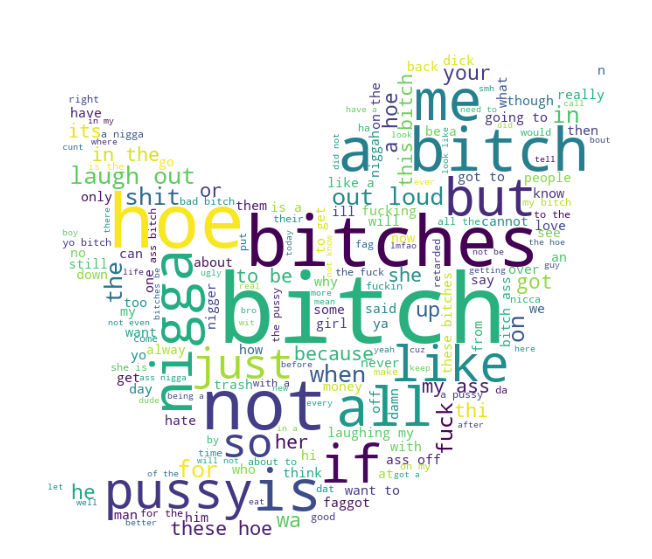

In [282]:
# visualize most commonly used words for hate/offensive speech
mask = np.array(Image.open('twitter_bird.JPG'))
hate_words = ' '.join([text for text in data['cleaned'][data['class'] == 0]])
wordcloud = WordCloud(mask = mask, width=800, height=500, random_state=21,min_font_size = 10, max_font_size=110, background_color="white",stopwords=['USER','HTTPURL','it','i','am','and','do','you','are','they','that']).generate(hate_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud)
plt.axis('off')
#plt.title('Word Cloud of Hate Speech Words', fontsize = 16)
plt.show()